In [1]:
import torch
import numpy as np
from torch.utils import data
from torch.nn import init
from matplotlib import pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
#加载数据集
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True,
download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False,
download=True, transform=transforms.ToTensor())

#定义训练参数
batch_size, num_epochs, lr = 128, 20, 0.1

#划分数据集
temp = []
for i in range(5000):
    temp.append(list(mnist_train[i]))
train_iter = torch.utils.data.DataLoader(temp, batch_size=batch_size, shuffle=True,num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=0)

#定义模型参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256

#定义损失函数
loss = torch.nn.CrossEntropyLoss()

#定义L2正则化函数
def l2_penalty(w):
    return (w**2).sum()/2

#定义linear层函数
def linear(X, w, b):
    return torch.matmul(X, w.t())+ b

#定义隐藏层激活函数
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

#定义分类模型
def net(X):
    X = X.view((-1, num_inputs))          
    linear_1 = linear(X, W1, b1)
    H1 = relu(linear_1)            #第一层隐藏层
    linear_2 = linear(H1, W2, b2)
    H2 = relu(linear_2)            #第二层隐藏层
    linear_3 = linear(H2, W3, b3)
    return linear_3

#定义随机梯度下降函数
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad
        
#定义计算测试集损失函数
def evaluate_loss(data_iter, net):
    l, n = 0.0, 0
    for X, y in data_iter:
        l += loss(net(X),y).sum().item()
        n += y.shape[0]
    return l / n

#定义计算测试集准确率函数
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        X = X.view((-1, num_inputs)) 
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [3]:
# ======================= 惩罚权重为0，无L2正则化 ================================= #

#定义惩罚权重
lambd0 = 0

#定义随机初始化模型参数的函数
W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_hiddens)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, dtype=torch.float, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

#训练模型
loss_train0 = []
loss_test0 = []
acc_train0 = []
acc_test0 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y).sum() + lambd0 * l2_penalty(W1) + lambd0 * l2_penalty(W2) + lambd0 * l2_penalty(W3)
        l.backward()          #计算损失     
        SGD(params, lr)       #更新梯度
        W1.grad.data.zero_()  #梯度清零
        b1.grad.data.zero_()
        W2.grad.data.zero_()
        b2.grad.data.zero_()
        W3.grad.data.zero_()
        b3.grad.data.zero_()
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train0.append(train_l_sum/n)
    loss_test0.append(evaluate_loss(test_iter,net))
    acc_train0.append(train_acc_sum/n)
    acc_test0.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train0[epoch], loss_test0[epoch], acc_train0[epoch], acc_test0[epoch]))
print('L2 norm of W1: %f, L2 norm of W2: %f, L2 norm of W3: %f' % (W1.norm().item(), W2.norm().item(), W3.norm().item()))

epoch 1, loss_train 0.018398, loss_test 0.018134 , acc_train 0.121800, acc_test 0.100000 
epoch 2, loss_train 0.018185, loss_test 0.017462 , acc_train 0.181000, acc_test 0.272400 
epoch 3, loss_train 0.015240, loss_test 0.013237 , acc_train 0.312200, acc_test 0.354400 
epoch 4, loss_train 0.010853, loss_test 0.017624 , acc_train 0.444200, acc_test 0.383500 
epoch 5, loss_train 0.009594, loss_test 0.013373 , acc_train 0.536000, acc_test 0.408900 
epoch 6, loss_train 0.008549, loss_test 0.014663 , acc_train 0.594800, acc_test 0.432600 
epoch 7, loss_train 0.007630, loss_test 0.008855 , acc_train 0.630600, acc_test 0.567700 
epoch 8, loss_train 0.007229, loss_test 0.010487 , acc_train 0.648200, acc_test 0.585400 
epoch 9, loss_train 0.007125, loss_test 0.008660 , acc_train 0.660200, acc_test 0.595500 
epoch 10, loss_train 0.006387, loss_test 0.006600 , acc_train 0.697200, acc_test 0.648000 
epoch 11, loss_train 0.005818, loss_test 0.009572 , acc_train 0.726800, acc_test 0.559600 
epoch 12

In [5]:
# ================================= 惩罚权重为1 ================================= #

#定义惩罚权重
lambd1 = 1

#定义随机初始化模型参数的函数
W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_hiddens)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, dtype=torch.float, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

#训练模型
loss_train1 = []
loss_test1 = []
acc_train1 = []
acc_test1 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y).sum() + lambd1 * l2_penalty(W1) + lambd1 * l2_penalty(W2) + lambd1 * l2_penalty(W3)
        l.backward()          #计算损失     
        SGD(params, lr)       #更新梯度
        W1.grad.data.zero_()  #梯度清零
        b1.grad.data.zero_()
        W2.grad.data.zero_()
        b2.grad.data.zero_()
        W3.grad.data.zero_()
        b3.grad.data.zero_()
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train1.append(train_l_sum/n)
    loss_test1.append(evaluate_loss(test_iter,net))
    acc_train1.append(train_acc_sum/n)
    acc_test1.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train1[epoch], loss_test1[epoch], acc_train1[epoch], acc_test1[epoch]))
print('L2 norm of W1: %f, L2 norm of W2: %f, L2 norm of W3: %f' % (W1.norm().item(), W2.norm().item(), W3.norm().item()))

epoch 1, loss_train 0.032503, loss_test 0.018191 , acc_train 0.112000, acc_test 0.100000 
epoch 2, loss_train 0.018421, loss_test 0.018193 , acc_train 0.111200, acc_test 0.100000 
epoch 3, loss_train 0.018416, loss_test 0.018195 , acc_train 0.111200, acc_test 0.100000 
epoch 4, loss_train 0.018418, loss_test 0.018194 , acc_train 0.111200, acc_test 0.100000 
epoch 5, loss_train 0.018420, loss_test 0.018194 , acc_train 0.111200, acc_test 0.100000 
epoch 6, loss_train 0.018419, loss_test 0.018194 , acc_train 0.111200, acc_test 0.100000 
epoch 7, loss_train 0.018417, loss_test 0.018195 , acc_train 0.111200, acc_test 0.100000 
epoch 8, loss_train 0.018417, loss_test 0.018195 , acc_train 0.111200, acc_test 0.100000 
epoch 9, loss_train 0.018412, loss_test 0.018198 , acc_train 0.111200, acc_test 0.100000 
epoch 10, loss_train 0.018418, loss_test 0.018197 , acc_train 0.111200, acc_test 0.100000 
epoch 11, loss_train 0.018410, loss_test 0.018199 , acc_train 0.111200, acc_test 0.100000 
epoch 12

In [4]:
# ================================= 惩罚权重为2 ================================= #

#定义惩罚权重
lambd2 = 2

#定义随机初始化模型参数的函数
W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_hiddens)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, dtype=torch.float, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

#训练模型
loss_train2 = []
loss_test2 = []
acc_train2 = []
acc_test2 = []
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y).sum() + lambd2 * l2_penalty(W1) + lambd2 * l2_penalty(W2) + lambd2 * l2_penalty(W3)
        l.backward()          #计算损失     
        SGD(params, lr)       #更新梯度
        W1.grad.data.zero_()  #梯度清零
        b1.grad.data.zero_()
        W2.grad.data.zero_()
        b2.grad.data.zero_()
        W3.grad.data.zero_()
        b3.grad.data.zero_()
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    loss_train2.append(train_l_sum/n)
    loss_test2.append(evaluate_loss(test_iter,net))
    acc_train2.append(train_acc_sum/n)
    acc_test2.append(evaluate_accuracy(test_iter,net))
    print('epoch %d, loss_train %f, loss_test %f , acc_train %f, acc_test %f '% 
          (epoch+1, loss_train2[epoch], loss_test2[epoch], acc_train2[epoch], acc_test2[epoch]))
print('L2 norm of W1: %f, L2 norm of W2: %f, L2 norm of W3: %f' % (W1.norm().item(), W2.norm().item(), W3.norm().item()))

epoch 1, loss_train 0.033353, loss_test 0.018191 , acc_train 0.107400, acc_test 0.100000 
epoch 2, loss_train 0.018416, loss_test 0.018194 , acc_train 0.111200, acc_test 0.100000 
epoch 3, loss_train 0.018420, loss_test 0.018194 , acc_train 0.111200, acc_test 0.100000 
epoch 4, loss_train 0.018415, loss_test 0.018196 , acc_train 0.111200, acc_test 0.100000 
epoch 5, loss_train 0.018416, loss_test 0.018197 , acc_train 0.111200, acc_test 0.100000 
epoch 6, loss_train 0.018418, loss_test 0.018196 , acc_train 0.111200, acc_test 0.100000 
epoch 7, loss_train 0.018417, loss_test 0.018196 , acc_train 0.111200, acc_test 0.100000 
epoch 8, loss_train 0.018412, loss_test 0.018198 , acc_train 0.111200, acc_test 0.100000 
epoch 9, loss_train 0.018418, loss_test 0.018197 , acc_train 0.111200, acc_test 0.100000 
epoch 10, loss_train 0.018415, loss_test 0.018197 , acc_train 0.111200, acc_test 0.100000 
epoch 11, loss_train 0.018418, loss_test 0.018197 , acc_train 0.111200, acc_test 0.100000 
epoch 12

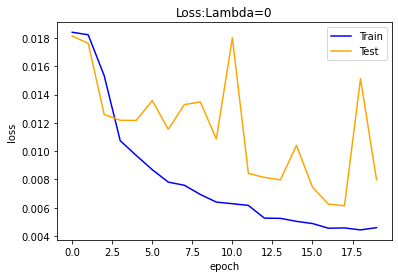

In [9]:
plt.plot(loss_train0,label='Train',color='blue')
plt.plot(loss_test0,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Lambda=0")
plt.legend()
plt.show()

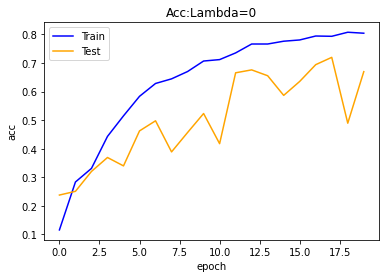

In [10]:
plt.plot(acc_train0,label='Train',color='blue')
plt.plot(acc_test0,label='Test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("Acc:Lambda=0")
plt.legend()
plt.show()

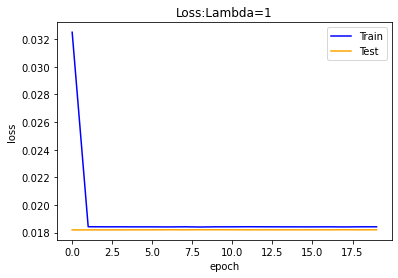

In [11]:
plt.plot(loss_train1,label='Train',color='blue')
plt.plot(loss_test1,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Lambda=1")
plt.legend()
plt.show()

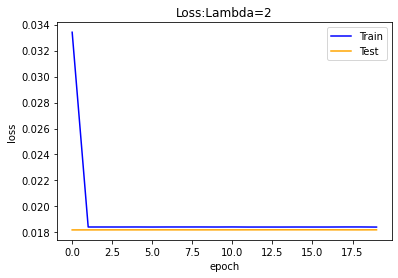

In [12]:
plt.plot(loss_train2,label='Train',color='blue')
plt.plot(loss_test2,label='Test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Loss:Lambda=2")
plt.legend()
plt.show()